In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import gmaps
import requests
from api_key import census_api
from api_key import g_key


from census import Census
c = Census(census_api, year=2018)

In [2]:
csv_read = pd.read_csv("../cleaned_2018_texas_accidents.csv")
texas_accidents_df = pd.DataFrame(csv_read)
texas_accidents_df = texas_accidents_df.sort_values("County")
texas_accidents_df.head()

,Unnamed: 0,Time,Latitude,Longitude,City,County,State,Zipcode,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Weather_Condition,Year,Month,Day
5470,262749,2018-02-21 10:49:54,31.371149,-94.722473,Lufkin,Angelina,TX,75904-1233,55.9,100.0,30.14,4.0,9.2,0.13,Light Rain,2018,2,21
415,199498,2018-12-14 06:58:49,31.129475,-94.318848,Zavalla,Angelina,TX,75980,43.0,97.0,29.78,10.0,6.9,0.00,Overcast,2018,12,14
2192,214086,2018-10-24 07:57:14,30.175158,-97.527016,Cedar Creek,Bastrop,TX,78612,57.9,93.0,30.03,10.0,9.2,0.00,Light Rain,2018,10,24
1767,212533,2018-10-16 12:51:16,30.319321,-97.443939,Elgin,Bastrop,TX,78621-4147,46.4,100.0,30.20,3.0,15.0,0.02,Light Rain,2018,10,16
2225,214143,2018-10-24 16:49:49,31.101995,-97.359596,Temple,Bell,TX,76504,60.1,100.0,30.01,4.0,9.2,0.29,Light Rain,2018,10,24


In [3]:
texas_accidents_df = texas_accidents_df[['Time', 'Latitude', 'Longitude', 'City', 'County',
       'State', 'Zipcode', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Weather_Condition', 'Year', 'Month', 'Day']]

In [4]:

group_county = texas_accidents_df.groupby("County")
count_per_county = group_county["Time"].count()
count_per_county.head(20)

County
Angelina        2
Bastrop         2
Bell           12
Bexar         871
Bowie           3
Brazoria       22
Caldwell        4
Cameron         4
Childress       1
Clay            2
Collin         23
Comal           2
Cooke           1
Dallas       1806
Denton        156
Dimmit          1
Ector           2
El Paso       211
Ellis           7
Fayette         1
Name: Time, dtype: int64

In [5]:
csv_read = pd.read_csv("texas_population_by_county.csv")
county_pop_df = pd.DataFrame(csv_read)

In [6]:
county_pop_df = county_pop_df[['CTYNAME', 'YEAR', 'POPESTIMATE',
                              'UNDER5_TOT', 'AGE513_TOT', 'AGE1417_TOT']]
county_pop_df["Driving_pop"] = county_pop_df['POPESTIMATE'] - county_pop_df['UNDER5_TOT'] - county_pop_df['AGE513_TOT'] - county_pop_df['AGE1417_TOT']
county_pop_df.head()

,CTYNAME,YEAR,POPESTIMATE,UNDER5_TOT,AGE513_TOT,AGE1417_TOT,Driving_pop
0,Anderson County,1,58458,3135,5805,2535,46983
1,Anderson County,2,58452,3135,5804,2534,46979
2,Anderson County,3,58493,3129,5780,2526,47058
3,Anderson County,4,58394,3105,5812,2518,46959
4,Anderson County,5,58059,2999,5796,2456,46808


In [7]:
full_county_list = texas_accidents_df["County"].unique()
drive_pop_list = []
county_list = []
for county in full_county_list:
    for index, pop in county_pop_df.iterrows():
        if county_pop_df.loc[index, 'CTYNAME'] == county + " County" and county_pop_df.loc[index, "YEAR"] ==11:
            drive_pop_list.append(county_pop_df.loc[index, 'Driving_pop'])
            county_list.append(county)
            

In [42]:
county_pop_accident_df = pd.DataFrame({'County':county_list,
                                      'Driving_Age_Population':drive_pop_list
                                     }) 
county_pop_accident_df = pd.merge(county_pop_accident_df, count_per_county, on='County')
county_pop_accident_df['perc_by_1000_pop'] = round((county_pop_accident_df['Time']/(county_pop_accident_df['Driving_Age_Population']/1000))*100, 0)
county_pop_accident_df = county_pop_accident_df.sort_values('perc_by_1000_pop')
county_pop_accident_df

,County,Driving_Age_Population,Time,perc_by_1000_pop
50,Nueces,273118,3,1.0
7,Cameron,293892,4,1.0
44,McLennan,191436,1,1.0
16,Ector,112914,2,2.0
62,Tom Green,89847,2,2.0
...,...,...,...,...
49,Nolan,10953,6,55.0
3,Bexar,1475472,871,59.0
38,Kimble,3568,3,84.0
13,Dallas,1942201,1806,93.0


In [50]:
bins = [0, 70000, 600000, 3500000]
group_names = ['small', 'medium', 'large']
county_pop_accident_df["population_level"] = pd.cut(county_pop_accident_df["Driving_Age_Population"], bins, labels=group_names, include_lowest=True)
county_pop_accident_df

,County,Driving_Age_Population,Time,perc_by_1000_pop,population_level
50,Nueces,273118,3,1.0,medium
7,Cameron,293892,4,1.0,medium
44,McLennan,191436,1,1.0,medium
16,Ector,112914,2,2.0,medium
62,Tom Green,89847,2,2.0,medium
...,...,...,...,...,...
49,Nolan,10953,6,55.0,small
3,Bexar,1475472,871,59.0,large
38,Kimble,3568,3,84.0,small
13,Dallas,1942201,1806,93.0,large


In [51]:
min_county = []
max_county = []
for index, row in county_pop_accident_df.iterrows():
    if county_pop_accident_df.loc[index, 'perc_by_1000_pop'] == county_pop_accident_df['perc_by_1000_pop'].min():
        min_county.append(county_pop_accident_df.loc[index, 'County'])
    if county_pop_accident_df.loc[index, 'perc_by_1000_pop'] == county_pop_accident_df['perc_by_1000_pop'].max():
        max_county.append(county_pop_accident_df.loc[index, 'County'])

print(f'The county(ies) with the lowest accident rate per 1000 population within the legal driving age is/are {min_county}.')
print(f'The county(ies) with the hughest accident rate per 1000 population within the legal driving age is/are {max_county}.')

The county(ies) with the lowest accident rate per 1000 population within the legal driving age is/are ['Nueces', 'Cameron', 'McLennan'].
The county(ies) with the hughest accident rate per 1000 population within the legal driving age is/are ['Travis'].


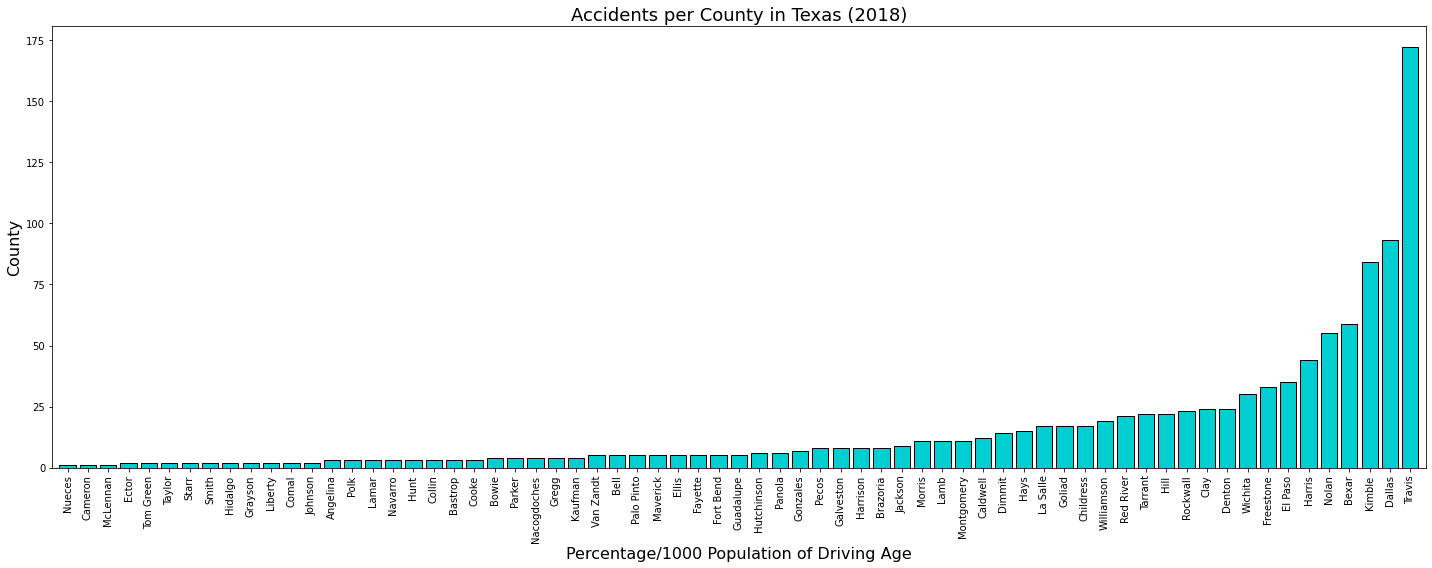

In [45]:
x_axis = county_pop_accident_df["County"]
plt.figure(figsize=(20,8), tight_layout=True, edgecolor='grey')
plt.xlim(-0.75, len(x_axis)-0.25)
plt.xticks(rotation="vertical")
plt.bar(x_axis, county_pop_accident_df['perc_by_1000_pop'], color="darkturquoise", edgecolor="black")
plt.title("Accidents per County in Texas (2018)", fontsize=18)
plt.ylabel("County", fontsize=16)
plt.xlabel("Percentage/1000 Population of Driving Age", fontsize=16)
plt.savefig("Images/accident_per_county_bar.png")
plt.show()

In [52]:
small_x_axis = []
small_y_axis = []
medium_x_axis = []
medium_y_axis = []
large_x_axis = []
large_y_axis= []
for index, row in county_pop_accident_df.iterrows():
    if county_pop_accident_df.loc[index, "population_level"] == "small":
        small_x_axis.append(county_pop_accident_df.loc[index, 'County'])
        small_y_axis.append(county_pop_accident_df.loc[index, 'perc_by_1000_pop'])
    elif county_pop_accident_df.loc[index, 'population_level'] == "medium":
        medium_x_axis.append(county_pop_accident_df.loc[index, 'County'])
        medium_y_axis.append(county_pop_accident_df.loc[index, 'perc_by_1000_pop'])
    else:
        large_x_axis.append(county_pop_accident_df.loc[index, 'County'])
        large_y_axis.append(county_pop_accident_df.loc[index, 'perc_by_1000_pop'])
       
                                                    

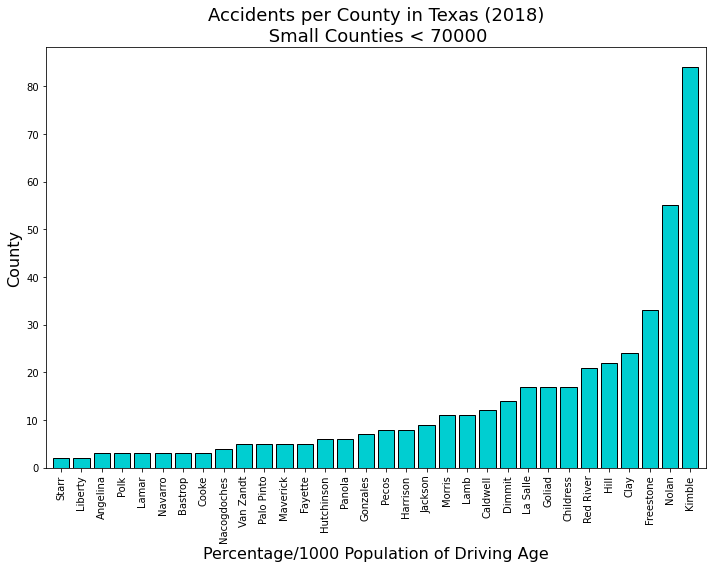

In [53]:
plt.figure(figsize=(10,8), tight_layout=True, edgecolor='grey')
plt.xlim(-0.75, len(small_x_axis)-0.25)
plt.xticks(rotation="vertical")
plt.bar(small_x_axis, small_y_axis, color="darkturquoise", edgecolor="black")
plt.title("Accidents per County in Texas (2018)\n Small Counties < 70000", fontsize=18)
plt.ylabel("County", fontsize=16)
plt.xlabel("Percentage/1000 Population of Driving Age", fontsize=16)
plt.savefig("Images/accident_per_small_county_bar.png")
plt.show()

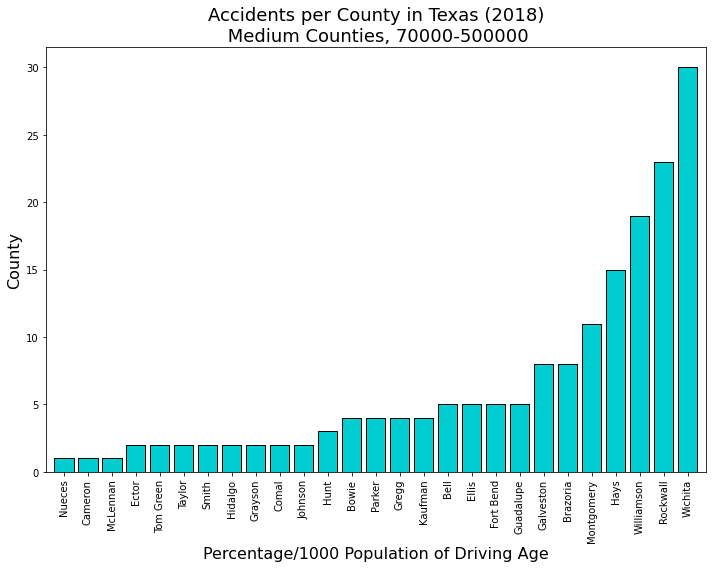

In [54]:
plt.figure(figsize=(10,8), tight_layout=True, edgecolor='grey')
plt.xlim(-0.75, len(medium_x_axis)-0.25)
plt.xticks(rotation="vertical")
plt.bar(medium_x_axis, medium_y_axis, color="darkturquoise", edgecolor="black")
plt.title("Accidents per County in Texas (2018)\n Medium Counties, 70000-500000", fontsize=18)
plt.ylabel("County", fontsize=16)
plt.xlabel("Percentage/1000 Population of Driving Age", fontsize=16)
plt.savefig("Images/accident_per_medium_county_bar.png")
plt.show()

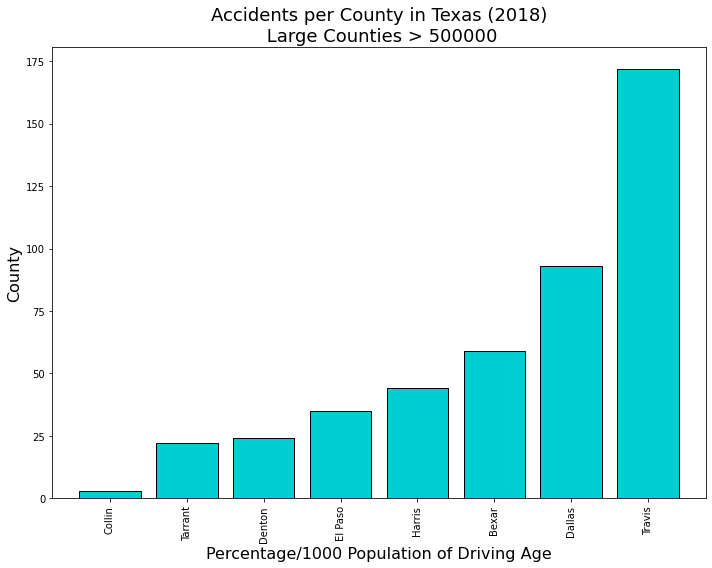

In [55]:
plt.figure(figsize=(10,8), tight_layout=True, edgecolor='grey')
plt.xlim(-0.75, len(large_x_axis)-0.25)
plt.xticks(rotation="vertical")
plt.bar(large_x_axis, large_y_axis, color="darkturquoise", edgecolor="black")
plt.title("Accidents per County in Texas (2018)\n Large Counties > 500000", fontsize=18)
plt.ylabel("County", fontsize=16)
plt.xlabel("Percentage/1000 Population of Driving Age", fontsize=16)
plt.savefig("Images/accident_per_large_county_bar.png")
plt.show()

In [ ]:
lat = []
lng = []
for county in county_list:
    components = "components=country:US|administrative_area:" + county + ",TX"
    base_url = "https://maps.googleapis.com/maps/api/geocode/json?key=" + g_key + "&" + components
    county_data = requests.get(base_url).json()
    lat.append(county_data['results'][0]['geometry']['location']["lat"])
    lng.append(county_data['results'][0]['geometry']['location']["lng"])
    

In [ ]:
county_pop_accident_df["Latitude"] = lat
county_pop_accident_df['Longitude'] = lng


In [ ]:
gmaps.configure(api_key=g_key)
layout={'width': '550px', 'height': '550px', 'border': '1px solid black'} 

accidents = county_pop_accident_df['perc_by_1000_pop']
locations = county_pop_accident_df[["Latitude", "Longitude"]]
fig = gmaps.figure(zoom_level=5, center = (31,-100), layout=layout)

heat_layer = gmaps.heatmap_layer(locations, weights=accidents, 
                                 dissipating=False, max_intensity=180,
                                 point_radius=1)


# Add layer
fig.add_layer(heat_layer)

# Display figure
fig